In [1]:
###Importamos las bibliotecas necesarias:
##TensorFlow, Keras a partir de TensorFlow; y de Keras además importamos el comando para crear capas
import tensorflow as tf #Importamos TensorFlow
from tensorflow import keras #Importamos keras desde TensorFlow
from tensorflow.keras import layers #Importamos la función para crear capas de redes neuronales desde keras
from tensorflow.keras.models import Model #Importamos la clase Model de tensorflow, lo que permite crear modelos de DL como clases, con arquitecturas más complejas que usar Sequential
from tensorflow.keras.callbacks import EarlyStopping #Importamos la función para realizar el earlystopping desde la biblioteca de callbacks de keras
from tensorflow.keras.models import load_model #Cargamos la función para poder importar modelos de machine learning
from tensorflow.keras.utils import plot_model #Cargamos la función para poder realizar representaciones de la arquitectura de modelos
from keras.saving import register_keras_serializable #Función de queras necesaria para guardar modelos que se hayan definidos como clases

##Importamos keras tuning para poder optimizar los hiperparámetros del modelo
import keras_tuner as kt

##Importamos cuda para poder liberar el espacio de la GPU
from numba import cuda

##Importamos Pandas para trabajar con DataFrames
import pandas as pd

##Importamos Numpy para incluir más funciones matematicas
import numpy as np

##Importamos la biblioteca itertools para tener herramientas de iteración sobre diferentes conjuntos
import itertools

##Importamos MatPlotLib para realizar representaciones
import matplotlib.pyplot as plt
from matplotlib import gridspec #Es un paquete de matplotlib que permite realizar figuras de varias subfiguras

##Importamos la función display de la biblioteca IPython.display, que permite mostrar contenido de manera más enriquecida
from IPython.display import display
from IPython.display import Image

##Importamos varias funciones de las bibliotecas de sklearn
from sklearn.model_selection import train_test_split #Es una función que se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de forma aleatoria.
from sklearn.metrics import accuracy_score, precision_score, recall_score #Funciones para evaluar el rendimiento de modelos de clasificcación: accuracy_score() fracción de muestras clasificadas correctaente (precisión del modelo), precision_score() precisión para una clase en particular, recall_score() sensibilidad para cada clase (tasa de verdaderos positivos)

##Importamos el modulo time para poder medir el tiempo de ejecución del código
import time

##Immportamos el generador de números aleatorios
import random

2024-06-17 07:18:35.866382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 07:18:35.910621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 07:18:36.660943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
##Función para establecer la sesión de tensorflow de tal manera que solo use un tercio de la memoria de la GPU. Siempre ejecutar esta celda
def set_tf_session(gpu_memory = 0.20):
    #Establecemos la fraccion de memoria de GPU a utilizar en la sesión. Por defecto emplea el 100%
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = gpu_memory)
    #Iniciamos la sesión de tensorflow con la fracción de memoria que hemos establecido
    sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))
    return sess

#Iniciamos la sesión con la fracción de memoria deseada de GPU
set_tf_session()

2024-06-17 07:18:40.869000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [3]:
#Función para normalizar las señales. Proporciona dos opciones: 1 para normalizar a [0,1] y 2 para normalizar respecto al valor máximo
#Por defecto normaliza a escala [0,1]
def normalizacion(df, tipo = 1):
    #Normalización [0,1]
    if tipo == 1:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximo de las filas
        minimos_fila = df.min(axis = 1).to_numpy() #Extraemos el valor mínimo de las filas
        df = (df - minimos_fila[:, None])/(maximos_fila[:, None] - minimos_fila[:, None]) #Normalizamos los valores del Dataframe
        return df
    
    #Normalización respecto al máximo
    if tipo == 2:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximos de las filas
        df = df/maximos_fila[:, None] #Dividimos cada fila por su máximo
        return df

In [4]:
##Función para cambiar el formato del input del autoencoder y que sea compatible con papas convolucionales 1D
def convert_to_tensor(df):
    #Convertimos el dataframe a un tensor
    tensor = tf.convert_to_tensor(df, dtype = tf.float32)
    #Añadimos la dimensión de canal 
    tensor = tf.expand_dims(tensor, axis = 2)
    return tensor

In [5]:
##Definimos un modelo de Autoencoder convolucional para tratar de reducir las señales.
#Este modelo trata de comprimir la señal, pero no extraé parametros que caractericen la señal.
@register_keras_serializable()
class Convolutional_AE1(Model):
    ##Creamos la función que inicializa el modelo de autoencoder convolucional
    #Como argumento de la clase toma un diccionario de los hiperparámetros requeridos por el modelo
    def __init__(self, hyper_params,  **kwargs):
        #Inicializamos la clase padre del modelo para poder emplear sus atributos
        super(Convolutional_AE1, self).__init__(**kwargs)

        #Definimos las características de las diferentes capas como parametrs ajustables del modelo
        self.hyper_params = hyper_params #Definimos el diccionario de hiperparámetros como una variable de clase
        self.filters_c1 = self.hyper_params["filters_c1"] #Filtros del primer bloque convolucional del encoder y último del decoder
        self.filters_c2 = self.hyper_params["filters_c2"] #Filtros del segundo bloque convolucional del encoder y penúltimo del decoder
        self.kernel_size_c1 = self.hyper_params["kernel_size_c1"] #Tamaño del kernel en el primer bloque convolucional del encoder y último del decoder
        self.kernel_size_c2 = self.hyper_params["kernel_size_c2"] #Tamaño del kernel en el segundo bloque convolucional del encoder y penúltimo del decoder
        self.kernel_size_c3 = self.hyper_params["kernel_size_c3"] #Tamaño del kernel en la última capa del encoder y primera del decoder
        self.l1_penalty = self.hyper_params["l1_penalty"] #Factor de penalización lineal a las capas
        self.l2_penalty = self.hyper_params["l2_penalty"] #Factor de penalización cuadrático a las capas


        #Definimos la parte del encoder (codificación de la señal al espacio de dimensión reducida), como una serie de bloques convolucionales
        self.encoder = keras.Sequential([
            #Definimos la capa de entrada para definir el tamaño de los datos de entrada
            layers.Input(shape = [100, 1]),

            #Definimos el primer bloque convolucional, que va a extraer características de la señal y reducir la dimensión de los datos a la mitad
            layers.Conv1D(filters = self.filters_c1, kernel_size = self.kernel_size_c1, padding = "valid", strides = 1, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.MaxPool1D(pool_size = 2, padding = "valid"),

            #Definimos el segundo bloque convolucional, que va a extraer características de la señal y reducir la dimensión de los datos a la mitad
            layers.Conv1D(filters = self.filters_c2, kernel_size = self.kernel_size_c2, padding = "valid", strides = 1, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.MaxPool1D(pool_size = 2, padding = "valid"),

            #Definimos el tercer bloque convolucional, que va a extraer  característica de la señal y reducir la dimensión de los datos a la mitad
            layers.Conv1D(filters = 1, kernel_size = self.kernel_size_c3, padding = "valid", strides = 1, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.MaxPool1D(pool_size = 2, padding = "valid"),
        ])

        #Definimos la parte del decoder (reconstrucción de la señal), como una serie de bloques convolucionales transpuestos
        self.decoder = keras.Sequential([
            #Defnimos la dimensión de la capa de entrada en funcion de la dimension de la salida del encoder
            layers.Input(shape = self.encoder.output_shape[1:]), 

            #Definimos el primer bloque convolucional que va a extraer una característica y duplicar el tamaño de la señal
            layers.Conv1DTranspose(filters = 1, kernel_size = self.kernel_size_c3, padding = "valid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.UpSampling1D(size = 2),

            #Definimos el segundo bloque convolucional que va a extraer características y duplicar el tamaño de la señal
            layers.Conv1DTranspose(filters = self.filters_c2, kernel_size = self.kernel_size_c2, padding = "valid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.UpSampling1D(size = 2),

            #Definimos el tercer bloque convolucional que va a extraer características y duplicar el tamaño de la señal
            layers.Conv1DTranspose(filters = self.filters_c1, kernel_size = self.kernel_size_c1, padding = "valid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)),
            layers.Activation("relu"),
            layers.UpSampling1D(size = 2),

            #Definimos la capa de salida que va a reconstruir la señal a traves de las características extraidas en las capas convolucionales
            layers.Flatten(), #Aplanamos la señal para poder meterla en una capa densa
            layers.Dense(units = 100, activation = "sigmoid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)), #Función de activacion sigmoid
        ])

    #Definimos el método call del modelo para estrablecer como debe ser la topología de la red al aplicarse sobre un conjunto de datos de entrada
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    #Modificamos las funciones de get_config() y from_config() para que la serializacion del modelo al guardarlo se haga correctamente
    def get_config(self):
        config = super(Convolutional_AE1, self).get_config()
        config.update({
            'hyper_params': self.hyper_params,
        })
        return config

    @classmethod
    def from_config(cls, config):
        hyper_params = config.pop('hyper_params')
        return cls(hyper_params, **config)

In [6]:
##Una vez definido el modelo de autoencoder debemos definir el hipermodelo asociado a dicho modelo para poder ajustar los hiperparámetros que hemos dejado libres en la arquitectura del modelo.
#Para ello instanciamos la clase que define el autoencoder dentro de una nueva clase kt.HyperModel que vamos a definir para poder optimizar los hiperparámetros
class CAE_1_HyperModel(kt.HyperModel):
    #En primer lugar inicializamos la calse, donde se va a definir el diccionario que contiene los hiperparámetros que se quieren optimizar
    def __init__(self):
        self.hyper_params = {
            #Hiperparámetros asociados a la arquitectura del modelo
            "filters_c1" : lambda hp: hp.Int("filters_c1", min_value = 1, max_value = 10, step = 1), #Filtros del primer bloque convolucional del encoder y último del decoder
            "filters_c2": lambda hp: hp.Int("filters_c2", min_value = 1, max_value = 10, step = 1), #Filtros del segundo bloque convolucional del encoder y penúltimo del decoder
            "kernel_size_c1" : lambda hp: hp.Choice("kernel_size_c1", [3, 5, 7]), #Tamaño del kernel en el primer bloque convolucional del encoder y último del decoder
            "kernel_size_c2" : lambda hp: hp.Choice("kernel_size_c2", [3, 5, 7]), #Tamaño del kernel en el segundo bloque convolucional del encoder y penúltimo del decoder
            "kernel_size_c3" : lambda hp: hp.Choice("kernel_size_c3", [3, 5, 7]), #Tamaño del kernel en la última capa del encoder y primera del decoder

            #Pesos de las penalizaciones aplicadas al modelo. Combinacion de penalización lineal y cuadrática
            "l1_penalty" : lambda hp: hp.Choice("l1_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),
            "l2_penalty" : lambda hp: hp.Choice("l2_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),
            
            #Hiperparámetros del compilador del modelo
            "learning_rate" : lambda hp: hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]), #Ritmo de aprendizaje

            #Hiperparámetros del entrenamiento
            "batch_size" : lambda hp: hp.Int("batch_size", min_value = 50, max_value = 300, step = 50),
            "min_delta" : lambda hp: hp.Choice("min_delta", [0.01, 0.005, 0.001]), #Criterio de convergencia del early_stopping
            "patience" : lambda hp: hp.Int("patience", min_value = 50, max_value = 100, step = 10), #Número mínimo de iteraciones del early_stopping
        } 
    
    #Creamos el método build (constructor del hipermodelo), que va a definir el modelo teniendo en cuenta los diferentes hiperparámetros
    def build(self, hp):
        #Creamos el diccionario de hiperparámetros con los valores seleccionados en el constructor
        hyperparameters = {key: func(hp) for key, func in self.hyper_params.items()} #Para cada par (key, función que define cada hiperparámetro correspondiente) se devuelve el par (key, valor elegido de los posibles del hiperparámetros para probar)

        #Generamos el modelo añadiendo como argumentos los hiperparámetros definidos en el constructor
        autoencoder = Convolutional_AE1(hyperparameters)

        #Compilamos el modelo teniendo en cuenta los hiperparámetros
        autoencoder.compile(
            optimizer = keras.optimizers.Adam(learning_rate = hyperparameters["learning_rate"]), #Hiperparámetro asociado al ritmo de entrenamiento
            loss = keras.losses.MeanSquaredError(),
            metrics = [tf.keras.metrics.CosineSimilarity()],
        )
        return autoencoder

    #Sobreescribimos el método de entrenamiento para poder añadir ciertos hiperparámetros
    def fit(self, hp, model, *args, **kwargs):
        kwargs['batch_size'] = self.hyper_params["batch_size"](hp)
        kwargs['callbacks'] = [
            EarlyStopping(
                min_delta=self.hyper_params["min_delta"](hp),
                patience=self.hyper_params["patience"](hp),
                restore_best_weights=True
            )
        ]
        return model.fit(*args, **kwargs)

In [7]:
##Cargamos el conjunto de datos con el que vamos a trabajar, que en este caso son un conjunto de señales del core de AGATA
url = "/home/jupyter-manuel/Digiopt/Data/Core_signal.dat"
core_signals = pd.read_csv(url, sep = "\t", header = "infer", dtype = np.float64, chunksize = None)
##Normalizamos las señales de core en [0,1] para realizar el entrenamiento del autoencoder
core_norm = normalizacion(core_signals.copy())
##Dividimos las señales del core de AGATA en un conjunto de entrenamiento, un conjunto de validación y un conjunto test, con una proporcion del 80% para el conjunto de entrenamiento
#y un 10% para el conjunto de validación y otro 10% para el conjuto test
X_train, X_valid = train_test_split(core_norm, train_size = 0.80)
X_valid, X_test = train_test_split(X_valid, train_size = 0.50)

#Cambiamos el formato de los conjuntos de entrenamiento y de validación a tensores para que sean compatibles con capas convolucionales
X_train_tf = convert_to_tensor(X_train)
X_valid_tf = convert_to_tensor(X_valid)
X_test_tf = convert_to_tensor(X_test)

2024-06-17 07:18:57.128373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [8]:
# '''#Instanciamos el tuner para realizar la busqueda de los hiperparametros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo
# hipermodel = CAE_1_HyperModel()
# #Vamos a emplear el RandomSearch, pero tambien estan disponibles: GridSearch, BayesianOptimization, Hyperband y SklearnTuner
# tuner = kt.RandomSearch(
#     hipermodel,
#     objective = "val_loss",
#     max_trials = 30,
#     executions_per_trial = 2,
#     directory = "/home/jupyter-manuel/Digiopt/HyperModels",
#     project_name = "CAE_1_tuner_2",
# )'''

'#Instanciamos el tuner para realizar la busqueda de los hiperparametros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo\nhipermodel = CAE_1_HyperModel()\n#Vamos a emplear el RandomSearch, pero tambien estan disponibles: GridSearch, BayesianOptimization, Hyperband y SklearnTuner\ntuner = kt.RandomSearch(\n    hipermodel,\n    objective = "val_loss",\n    max_trials = 30,\n    executions_per_trial = 2,\n    directory = "/home/jupyter-manuel/Digiopt/HyperModels",\n    project_name = "CAE_1_tuner_2",\n)'

In [8]:
#Instanciamos el tuner para realizar la busqueda de los hiperparámetros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo
hipermodel = CAE_1_HyperModel()
#Vamos a emplear el metodo Hyperband, pero tambien estan disponibles: GridSearch, BayesianOptimization, RandomSearch y SklearnTuner
tuner = kt.Hyperband(
    hipermodel,
    objective = "val_loss",
    max_epochs = 300,
    factor = 3,
    hyperband_iterations = 3,
    directory = "/home/jupyter-manuel/Digiopt/HyperModels",
    project_name = "CAE_1_tuner_Hyperband",
)

Reloading Tuner from /home/jupyter-manuel/Digiopt/HyperModels/CAE_1_tuner_Hyperband/tuner0.json


In [9]:
##Realizamos la busqueda de hiperparámetros mediante el metodo .search() de la clase tuner
#Definimos el criterio de EarlyStopping para parar el proceso de búsqueda de hiperparámetros
early_stopping_search = EarlyStopping(
    min_delta = 0.001,
    patience = 100,
    restore_best_weights = True
)

#Iniciamos la búsqueda de hiperparámetros
tuner.search(
    X_train_tf, X_train_tf,
    validation_data = (X_valid_tf, X_valid_tf),
    callbacks = [early_stopping_search],
    batch_size = 150,
    epochs = 300
)


Search: Running Trial #287

Value             |Best Value So Far |Hyperparameter
2                 |4                 |filters_c1
6                 |8                 |filters_c2
3                 |7                 |kernel_size_c1
3                 |5                 |kernel_size_c2
5                 |3                 |kernel_size_c3
1e-06             |1e-07             |l1_penalty
1e-06             |1e-07             |l2_penalty
0.01              |0.01              |learning_rate
50                |50                |batch_size
0.005             |0.001             |min_delta
90                |50                |patience
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
1                 |0                 |tuner/round
0039              |None              |tuner/trial_id



Traceback (most recent call last):
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/hom

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/home/jupyter-manuel/.local/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "/opt/tljh/user/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/tljh/user/lib/python3.10/site-packages/h5py/_hl/files.py", line 562, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/opt/tljh/user/lib/python3.10/site-packages/h5py/_hl/files.py", line 235, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 102, in h5py.h5f.open
FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/jupyter-manuel/Digiopt/HyperModels/CAE_1_tuner_Hyperband/trial_0039/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [10]:
##Extraemos los mejores hiperparámetros buscados por el HyperModel mediante el método Hyperband
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

#Resultados obtenidos de los hiperparámetros
print("""Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: \n
Filtros 1º bloque convolucional = {} \n
Filtros 2º bloque convolucional = {} \n
Tamaño del kernel 1º bloque convolucional = {} \n
Tamaño del kernel 2º bloque convolucional = {} \n
Tamaño del kernel 3º bloque convolucional = {} \n
Penalizacion L1 = {} \n
Penalizacion L2 = {} \n
Tasa de aprendizaje = {} \n
Batch size = {} \n
Min delta = {} \n
Patience = {} \n
""".format(best_hps.get("filters_c1"), best_hps.get("filters_c2"), best_hps.get("kernel_size_c1"), best_hps.get("kernel_size_c2"), best_hps.get("kernel_size_c3"), best_hps.get("l1_penalty"), best_hps.get("l2_penalty"), best_hps.get("learning_rate"), best_hps.get("batch_size"), best_hps.get("min_delta"), best_hps.get("patience")))

##Una vez realizada la busqueda de hiperparámetros definimos un modelo de autoencoder que contenga los hiperparámetros optimizados
autoencoder = tuner.hypermodel.build(best_hps)

autoencoder.encoder.summary()
autoencoder.decoder.summary()

Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: 

Filtros 1º bloque convolucional = 4 

Filtros 2º bloque convolucional = 8 

Tamaño del kernel 1º bloque convolucional = 7 

Tamaño del kernel 2º bloque convolucional = 5 

Tamaño del kernel 3º bloque convolucional = 3 

Penalizacion L1 = 1e-07 

Penalizacion L2 = 1e-07 

Tasa de aprendizaje = 0.01 

Batch size = 50 

Min delta = 0.001 

Patience = 50 




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 94, 4)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 94, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 47, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 43, 8)          │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 43, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 21, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 1)          │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 19, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 9, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_transpose_3              │ (None, 11, 1)          │             4 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 11, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 22, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 26, 8)          │            48 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 26, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 52, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 58, 4)          │           228 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 58, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 116, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 464)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        46,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,780 (182.73 KB)

 Trainable params: 46,780 (182.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
##Pasamos a entrenar el modelo construido a partir de los hiperparámetros optimizados
#Definimos el criterio de convergencia en base a los hiperparámetros óptimos
early_stopping_fit = EarlyStopping(
    min_delta = 0.001,
    patience = 100,
    restore_best_weights = True
)

#Entrenamos el modelo con lo hiperparámetros óptimos
history = autoencoder.fit(
    X_train_tf, X_train_tf,
    validation_data = (X_valid_tf, X_valid_tf),
    callbacks = [early_stopping_fit],
    batch_size = 100,
    epochs = 700,
)

Epoch 1/700


I0000 00:00:1718350203.268353  878906 service.cc:145] XLA service 0x7efeac0074c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718350203.268409  878906 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-14 07:30:03.342835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 07:30:03.586950: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 38/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.9352 - loss: 0.0747

I0000 00:00:1718350205.272947  878906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - cosine_similarity: 0.9710 - loss: 0.0347 - val_cosine_similarity: 0.9926 - val_loss: 0.0104
Epoch 2/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9923 - loss: 0.0105 - val_cosine_similarity: 0.9924 - val_loss: 0.0102
Epoch 3/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9923 - loss: 0.0105 - val_cosine_similarity: 0.9927 - val_loss: 0.0099
Epoch 4/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9933 - loss: 0.0090 - val_cosine_similarity: 0.9951 - val_loss: 0.0059
Epoch 5/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9953 - loss: 0.0057 - val_cosine_similarity: 0.9959 - val_loss: 0.0048
Epoch 6/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9959 - loss: 0.0050 - val_cosine_similarity: 0.9960 - val_loss: 0.0047
Epoch 7/700
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.9959 - loss: 0.0048 - val_cosine_similarity: 0.9962 -

In [13]:
#Guardamos el modelo entrenado con los hiperparámetros óptimos
autoencoder.save("/home/jupyter-manuel/Digiopt/Models/CAE_1_HyperModel_Hyperband.keras")

Text(0.5, 1.0, 'Similaridad coseno')

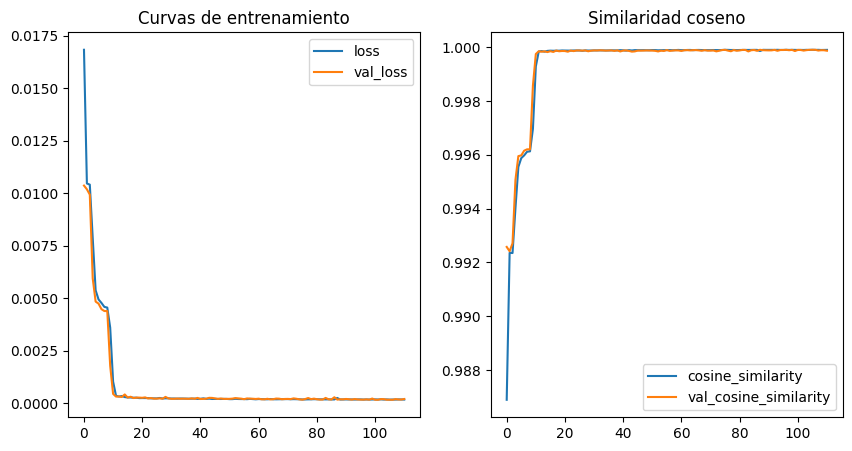

In [14]:
##Representamos las curvas de entrenamiento y las métricas empleadas en el proceso de entrenamiento
history_df = pd.DataFrame(history.history)

#Creamos la figura y la grid donde vamos a generar los gráficos
figure = plt.figure(figsize = (10, 5)) #Definimos la figura y su tamaño
grid = gridspec.GridSpec(1, 2, width_ratios = [1, 1]) #Definimos la grid con el número de filas y columnas

#Añadimos el primer gráfico al primer espacio de la cuadricula: curvas de entrenamiento (función de coste)
ax0 = plt.subplot(grid[0])
history_df.loc[:, ["loss", "val_loss"]].plot(ax = ax0) #Con el argumento de la funcion plot() ax = ax0 indicamos que el gráfico corresponde al hueco de la grid asociado a ax0
ax0.set_title("Curvas de entrenamiento")

#Añadimos el segundo gráfico al segundo espacio de la cuadricula: métricas calculadas en el proceso de entrenamiento (similaridad coseno)
ax1 = plt.subplot(grid[1])
history_df.loc[:, ["cosine_similarity", "val_cosine_similarity"]].plot(ax = ax1)
ax1.set_title("Similaridad coseno") 

In [11]:
##Cargamos el modelo entrenado y congelamos los pesos para que no se puedan modificcar en posibles procesos de entrenamiento
autoencoder = load_model("/home/jupyter-manuel/Digiopt/Models/CAE_1_HyperModel_Hyperband.keras", custom_objects = {'CAE_1': Convolutional_AE1})
autoencoder.trainable = False

#Aplicamos el encoder y el decoder a las señales del conjunto de validación, de tal manera que obtenemos la representacion en el espacio de dimensión reducida y la señal reconstruida
encoded_signal = autoencoder.encoder(X_valid_tf).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

#Calculamos el error de reconstrucción promedio dado por el autoencoder mediante el indicador MSE
rmse = np.sqrt(np.mean((X_valid - autoencoder.predict(X_valid)) ** 2))
print(rmse)

2024-06-17 07:20:11.604179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718608812.484903 1265975 service.cc:145] XLA service 0x7fcc28005a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718608812.484977 1265975 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-17 07:20:12.519449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


I0000 00:00:1718608812.826553 1265975 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0.016762777217122448


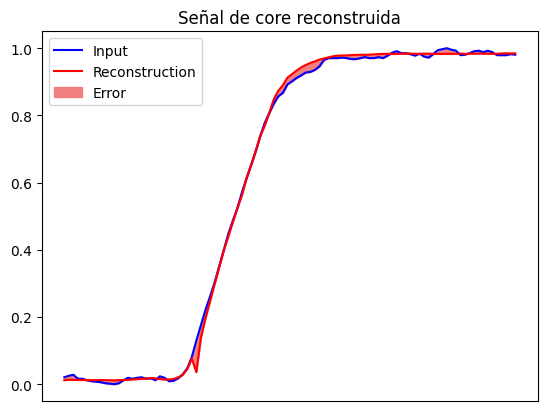

In [80]:
##Representamos en el mismo gráfico la señal original, la señal reconstruida y el error de reconstrucción para una señal aleatoria del conjunto de validación
n_random = random.randint(1, 170)
plt.plot(X_valid.iloc[n_random], "b")
plt.plot(decoded_signal[n_random], "r")
plt.fill_between(np.arange(100), decoded_signal[n_random], X_valid.iloc[n_random], color = "lightcoral")
plt.legend(labels = ["Input", "Reconstruction", "Error"])
plt.title("Señal de core reconstruida")
plt.xticks([])
plt.show()

,0,1,2,3,4,5,6,7,8
0,0.000000,0.443116,1.538072,2.746994,3.245775,3.265777,3.240962,3.223412,3.222445
1,0.284759,0.952072,1.893170,2.894948,3.183406,3.207096,3.224280,3.196432,3.136391
2,0.000000,0.275543,1.154478,2.353503,3.172815,3.255229,3.232920,3.230401,3.242269
3,0.000000,0.311423,1.165798,2.196956,2.975311,3.228718,3.266413,3.253485,3.253976
4,0.000000,0.265052,1.084838,2.301483,3.161082,3.243265,3.270555,3.261562,3.216287
...,...,...,...,...,...,...,...,...,...
15609,0.000000,0.030844,0.399140,1.426672,2.778440,3.235862,3.260081,3.262671,3.265613
15610,0.000000,0.018455,0.474311,1.297027,2.355718,3.140701,3.251239,3.264569,3.266746
15611,0.000000,0.179002,1.389148,2.277515,2.793784,3.159254,3.257771,3.253004,3.251088
15612,0.613526,1.710259,2.853807,3.179443,3.171443,3.203468,3.212715,3.229761,3.227317


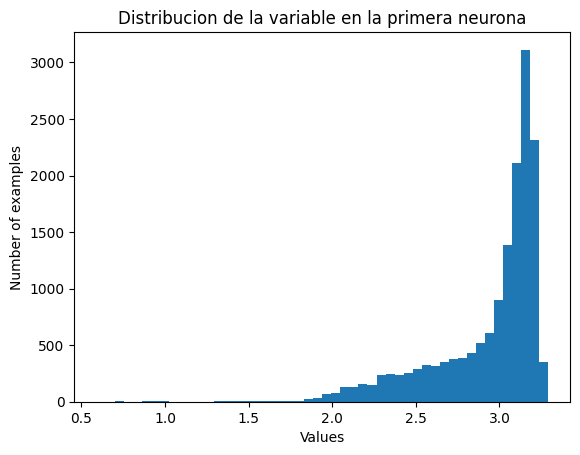

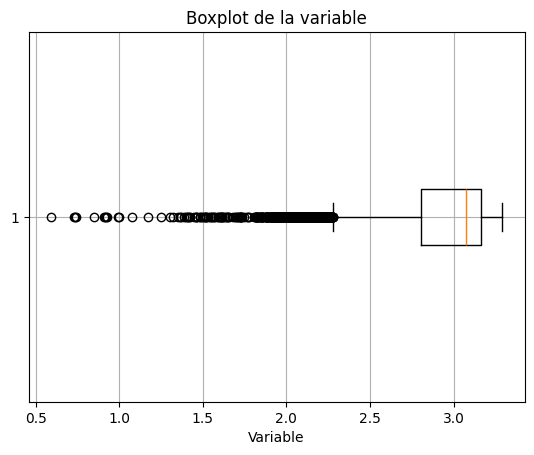

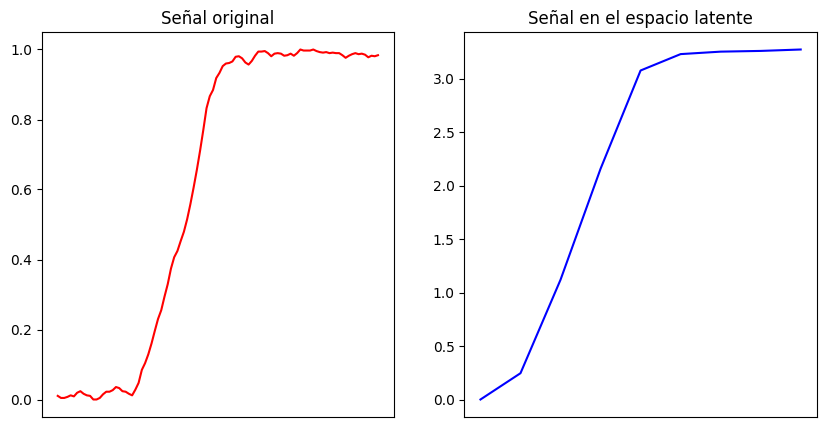

In [37]:
##Para obtener las señales en el espacio de dimensión reducida aplicamos la parte del encoder del autoencoder a las señales de entrada
reduced_signal = tf.squeeze(autoencoder.encoder(X_train_tf)).numpy() #Eliminamos las dimensiones del tensor que sean 1
reduced_signal_df = pd.DataFrame(reduced_signal)
display(reduced_signal_df)

#Distribucion de la variable guardada en la primera neurona
plt.hist(reduced_signal_df[4], bins = 50)
plt.title("Distribucion de la variable en la primera neurona")
plt.xlabel("Values")
plt.ylabel("Number of examples")
plt.show()

#Boxplot de la variables guardada en la primera neurona
plt.boxplot(reduced_signal_df[4], vert=False)  
plt.title('Boxplot de la variable')
plt.xlabel('Variable')
plt.grid(True)
plt.show()

#Representación de las señales en el espacio de dimensión reducida y la señal original a la que corresponde
n_random = random.randint(0, 1367)
# Crear una figura y dos subgráficos en una cuadrícula de 1x2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Graficar la señal reducida en el segundo subgráfico
axs[1].plot(reduced_signal_df.iloc[n_random], "b")
axs[1].set_title("Señal en el espacio latente")
axs[1].set_xticks([])

# Graficar la señal original en el primer subgráfico
axs[0].plot(X_train.iloc[n_random], "r")
axs[0].set_title("Señal original")
axs[0].set_xticks([])

plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


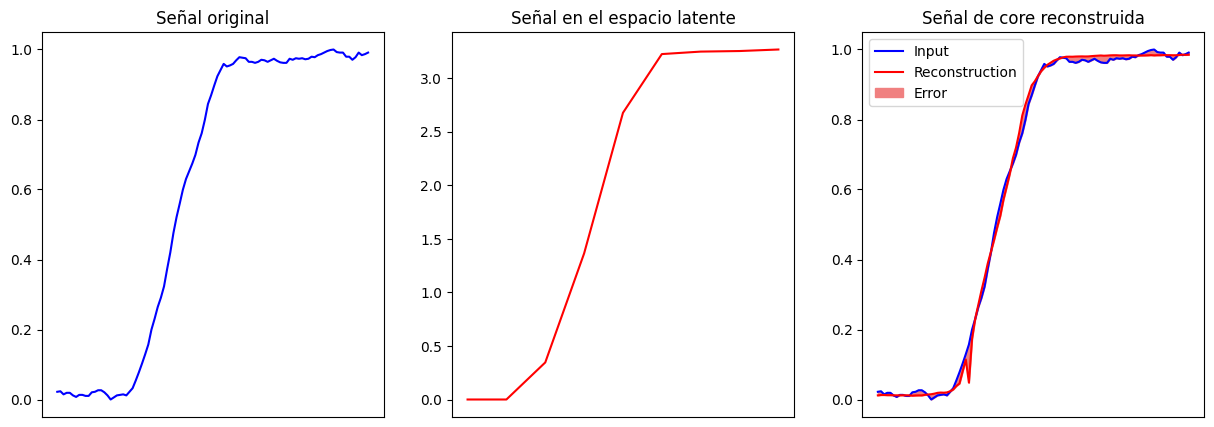

In [46]:
##Representamos a continuación tres graficos en los que se muestra lo siguiente: Señal original, señal en el espacio de dimension reducida
##Aplicamos el modelo al conjunto de test para determinar las reconstrucciones dadas por el modelo
reconstructed_test = autoencoder.predict(X_test)
#y la comparacion entre la señal original y la señal reconstruida.
n_random = random.randint(0, 171)
#Crear una figura y dos subgráficos en una cuadrícula de 1x3
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#Graficar la señal original en el primer subgráfico
axs[0].plot(X_test.iloc[n_random], "b")
axs[0].set_title("Señal original")
axs[0].set_xticks([])
#Graficar la señal reducida en el segundo subgráfico
axs[1].plot(reduced_signal_df.iloc[n_random], "r")
axs[1].set_title("Señal en el espacio latente")
axs[1].set_xticks([])
#Graficar la señal original y la señal reconstruida junto con el error de reconstrucción
axs[2].plot(X_test.iloc[n_random], "b")
axs[2].plot(reconstructed_test[n_random], "r")
axs[2].fill_between(np.arange(100), reconstructed_test[n_random], X_test.iloc[n_random], color = "lightcoral")
axs[2].legend(labels = ["Input", "Reconstruction", "Error"])
axs[2].set_title("Señal de core reconstruida")
axs[2].set_xticks([])

plt.show()

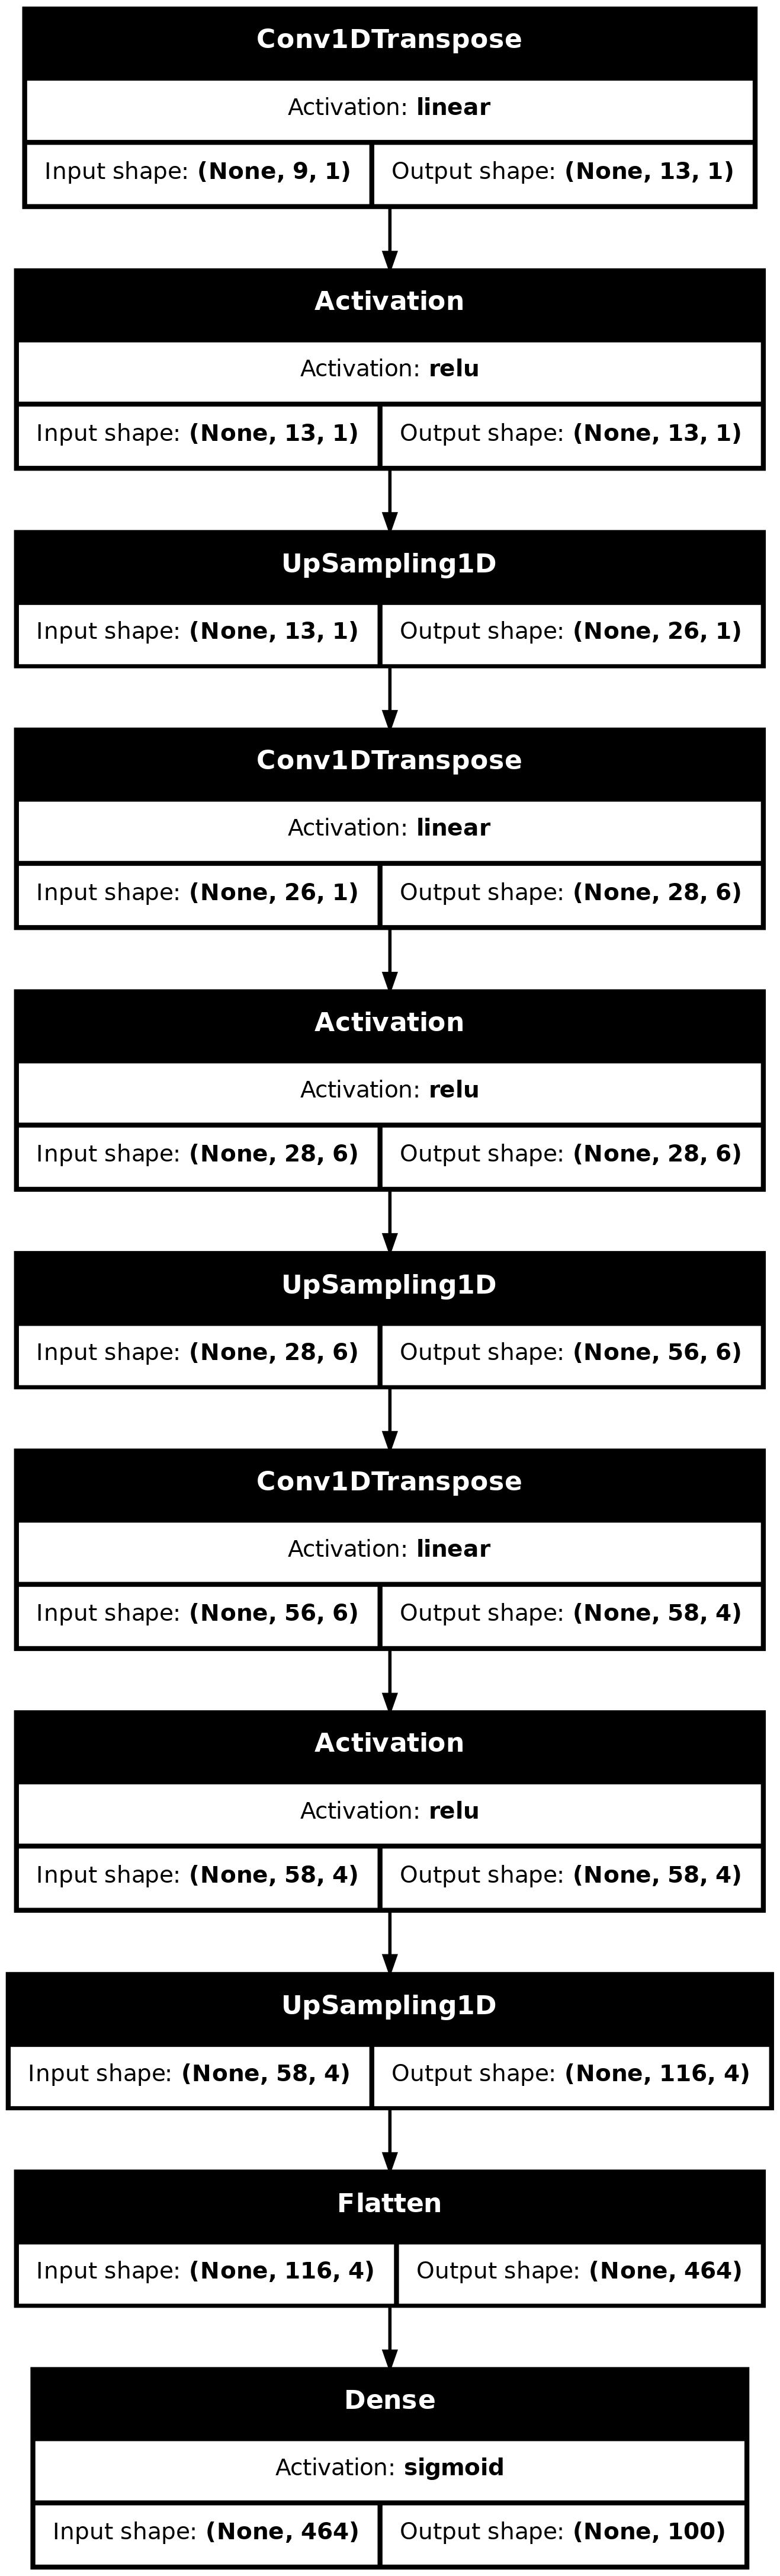

In [ ]:
#Generación de gráficos de arquitecturas
import graphviz
import pydotplus
#Generación del gráfico en un fichero
#Arquitectura encoder
plot_model(autoencoder.encoder, to_file='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/CAE_1_encoder.png', show_shapes = True, show_layer_activations = True)
#Arquitrectura decoder
plot_model(autoencoder.decoder, to_file='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/CAE_1_decoder.png', show_shapes = True, show_layer_activations = True)

#Mostrar la imagen del gráfico
Image(filename='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/CAE_1_encoder.png')
Image(filename='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/CAE_1_decoder.png')

In [47]:
##Ejecutar siempre que se quiera liberar el espacio de la GPU y al final de cada scrip
cuda.select_device(0)
cuda.close()